# Overview 

Within this notebook, we work through using the Multilayer Perceptron Classifier (MLPC) inside of Spark's MLlib.

### Install Dependencies

Please run each code chunk in this section prior to moving forward in the notebook! 

In [ ]:
#@title  <-- Run Me: (Hidden) Installing Spark
%%bash 

## Setup Spark on Colab
pip install -q pyspark
apt-get -qq install -y openjdk-8-jdk-headless

## Setup port-forwarding

# Download ngrok
wget -q https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
# Unload ngrok
unzip -q ngrok-stable-linux-amd64.zip

Selecting previously unselected package openjdk-8-jre-headless:amd64.
(Reading database ... 155501 files and directories currently installed.)
Preparing to unpack .../openjdk-8-jre-headless_8u312-b07-0ubuntu1~18.04_amd64.deb ...
Unpacking openjdk-8-jre-headless:amd64 (8u312-b07-0ubuntu1~18.04) ...
Selecting previously unselected package openjdk-8-jdk-headless:amd64.
Preparing to unpack .../openjdk-8-jdk-headless_8u312-b07-0ubuntu1~18.04_amd64.deb ...
Unpacking openjdk-8-jdk-headless:amd64 (8u312-b07-0ubuntu1~18.04) ...
Setting up openjdk-8-jre-headless:amd64 (8u312-b07-0ubuntu1~18.04) ...
update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/orbd to provide /usr/bin/orbd (orbd) in auto mode
update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/servertool to provide /usr/bin/servertool (servertool) in auto mode
update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/tnameserv to provide /usr/bin/tnameserv (tnameserv) in auto mode
Setting up ope

In [ ]:
#@title  <-- Run Me: (Hidden) Environment Variable Setup
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [ ]:
import pyspark 
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

# Set configuration scope to be local and use port 4050
config_scope = SparkConf().set("spark.ui.port", "4050")

# Create the connection to a Spark cluster
sc = pyspark.SparkContext(conf = config_scope)

# Create a session to programmatically build Spark RDD, DataFrame and DataSet
spark = SparkSession.builder.getOrCreate()

# Diagnostics

In [ ]:
#@title (Hidden) Diagnostic Check
import os
import sys
import pandas as pd
import numpy as np

print(f"python: {sys.version}")
print(f"pyspark: {sc.version}")
print(f"pandas: {pd.__version__}")
print(f"NumPy: {np.__version__}")

try:
  from google.colab import drive
  is_google_colab = True

  print("Notebook is on Google CoLab")
except:
  is_google_colab = False
  print("Notebook is being run locally or through another source.")


python: 3.7.13 (default, Mar 16 2022, 17:37:17) 
[GCC 7.5.0]
pyspark: 3.2.1
pandas: 1.3.5
NumPy: 1.21.6
Notebook is on Google CoLab


## Quick Neural Network

Many libraries exist to fit neural networks. The two most popular are [`Keras`](https://keras.io/) built ontop of [`TensorFlow`](https://tensorflow.org) and [`PyTorch`](https://pytorch.org/).



Consider the following network implementation in Keras.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Hyperparameters for our network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10      

# Build a feed-forward network
model = keras.Sequential([
  keras.Input(shape = (input_size,), name = "digits"),
  layers.Dense(hidden_sizes[0], activation = "relu", name = "hidden_1"),
  layers.Dense(hidden_sizes[1], activation = "relu", name = "hidden_2"),
  layers.Dense(output_size, activation = "softmax", name = "predictions")
])

# See model overview
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_1 (Dense)            (None, 128)               100480    
                                                                 
 hidden_2 (Dense)            (None, 64)                8256      
                                                                 
 predictions (Dense)         (None, 10)                650       
                                                                 
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


We specify the input and hidden layer size. From there, we request a non-linear activation before converting the estimate into a probability using softmax.

We can see a similar example with PyTorch:

In [ ]:
import torch
import torch.nn as nn

# Hyperparameters for our network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10      

# Build a feed-forward network
network = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[1], output_size),
    nn.Softmax(dim=1)
  )

# Display network
print(network)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): Softmax(dim=1)
)


The notable difference is in the need to specify: input and output parameters per layer and each activation function separately compared to Keras. 

## MLlib's Multilayer Perceptron Classifier (MLPC)

Spark has a multi-layer perceptron version inside of MLlib under `pyspark.ml` accessible with [`MultilayerPerceptronClassifier`](https://spark.apache.org/docs/latest/ml-classification-regression.html#multilayer-perceptron-classifier).

In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

Unlike the Keras and PyTorch equivalent, here we need to specify only the layer shapes. The activation function between intermediary layers will always be the sigmoid, $\sigma(z) = \frac{1}{1 + \exp{(-z)}}$, and the final activation function is $\text{softmax}(\mathbf{z}) = \frac{\exp{(z_i)}}{\sum_{j=1}^{k} \exp{(z_j)} }$. 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Read-in Train Data

Next, we can read in the data to Spark with:

In [ ]:
raw_train_data = spark.read.option("delimiter", "|").options(header = True, inferSchema = True).csv("/content/drive/MyDrive/train_data.csv")
raw_train_data.printSchema()

root
 |-- label: integer (nullable = true)
 |-- uid: integer (nullable = true)
 |-- task_id: integer (nullable = true)
 |-- adv_id: integer (nullable = true)
 |-- creat_type_cd: integer (nullable = true)
 |-- adv_prim_id: integer (nullable = true)
 |-- dev_id: integer (nullable = true)
 |-- inter_type_cd: integer (nullable = true)
 |-- slot_id: integer (nullable = true)
 |-- spread_app_id: integer (nullable = true)
 |-- tags: integer (nullable = true)
 |-- app_first_class: integer (nullable = true)
 |-- app_second_class: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- city: integer (nullable = true)
 |-- city_rank: integer (nullable = true)
 |-- device_name: integer (nullable = true)
 |-- device_size: integer (nullable = true)
 |-- career: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- net_type: integer (nullable = true)
 |-- residence: integer (nullable = true)
 |-- his_app_size: integer (nullable = true)
 |-- his_on_shelf_time: integer (nulla

In [ ]:
raw_train_data.count()

41907133

In [ ]:
raw_train_data.filter(train.label==1).count()

1445488

In [ ]:
raw_train_data.filter(train.label==0).count()

40461645

Let's take a look at the first five observations in training:

In [ ]:
#a,b = raw_train_data.randomSplit([0.2, 0.8])
train, test=raw_train_data.randomSplit([0.7, 0.3])

In [ ]:
train.show(5)

+-----+-------+-------+------+-------------+-----------+------+-------------+-------+-------------+----+---------------+----------------+---+----+---------+-----------+-----------+------+------+--------+---------+------------+-----------------+---------+--------+---------+------------+----------------+-------------------+------------------------+----------------+------------------------+---------------------------+---------+----+
|label|    uid|task_id|adv_id|creat_type_cd|adv_prim_id|dev_id|inter_type_cd|slot_id|spread_app_id|tags|app_first_class|app_second_class|age|city|city_rank|device_name|device_size|career|gender|net_type|residence|his_app_size|his_on_shelf_time|app_score|emui_dev|list_time|device_price|up_life_duration|up_membership_grade|membership_life_duration|consume_purchase|communication_onlinerate|communication_avgonline_30d|indu_name|pt_d|
+-----+-------+-------+------+-------------+-----------+------+-------------+-------+-------------+----+---------------+------------

In [ ]:
train.filter(train.label==1).count()

201820

In [ ]:
train.filter(train.label==0).count()

5664722

Notice, the data is stored by `_c{0-784}`. The data starts with `_c{0}` being the label and the features going from `_c{1}` to `_c{784}`. We can use a vector assembler to create a pair of the features and label.

In [ ]:
from pyspark.ml.feature import VectorAssembler


# Apply the transformation and rename columns
id_df = train.select("uid", "task_id","adv_id")
train_df=train.drop("uid", "task_id","adv_id","communication_onlinerate")

In [ ]:
# Dynamically generate name of columns
vecAssembler = VectorAssembler(
    inputCols = train_df.columns[1:],
    outputCol = "features")

# Apply the transformation
vec_data = vecAssembler.transform(train_df)
train_data_new=vec_data.select("label","features")


In [ ]:
train_data_new.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[6.0,132.0,60.0,3...|
|    0|[2.0,142.0,36.0,5...|
|    0|[8.0,142.0,36.0,5...|
|    0|[3.0,142.0,36.0,5...|
|    0|[7.0,207.0,17.0,5...|
+-----+--------------------+
only showing top 5 rows



Test data set

In [ ]:

id_df_test = test.select("uid", "task_id","adv_id")
test_df=test.drop("uid", "task_id","adv_id","communication_onlinerate")


In [ ]:
# Dynamically generate name of columns
vecAssembler = VectorAssembler(
    inputCols = test_df.columns[1:],
    outputCol = "features")

# Apply the transformation
vec_data = vecAssembler.transform(test_df)
test_data_new=vec_data.select("label","features")

In [ ]:
test_data_new.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[7.0,156.0,56.0,5...|
|    0|[7.0,207.0,17.0,5...|
|    0|[7.0,206.0,64.0,5...|
|    0|[7.0,156.0,56.0,5...|
|    0|[7.0,168.0,37.0,5...|
+-----+--------------------+
only showing top 5 rows



### Undersampling

In [ ]:
train1DF = train_data_new.where("label=1")
ONumber = train1DF.count()
train0DF = train_data_new.where("label=0")
ZNumber = train0DF.count()



In [ ]:
ratio = ONumber/(ZNumber)
sampleNormalDF = train0DF.sample(False, ratio, 10)
underDF = train1DF.union(sampleNormalDF)

In [ ]:
underDF.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    1|[7.0,206.0,64.0,5...|
|    1|[3.0,210.0,70.0,4...|
|    1|[7.0,104.0,37.0,5...|
|    1|[7.0,183.0,29.0,5...|
|    1|[3.0,210.0,70.0,4...|
+-----+--------------------+
only showing top 5 rows



In [ ]:
underDF.count()

406193

In [ ]:
underDF.where("label=1").count()

202637

In [ ]:
underDF.where("label=0").count()

203556

### Network: MLPC

Next, let's setup an MLPC that can handle the 784 features across four hidden layers.

In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

# Specify layers for the neural network:
# 1. input layer of size 784 (features),
# 2. one intermediate layer of size 128; and,
# 3. output of size 10 (classes)
layers = [31, 30,40, 2]

mlpc = MultilayerPerceptronClassifier(
  maxIter = 150, 
  layers = layers,
  blockSize = 20,
  #stepSize = 0.10, 
  seed = 1337,
  solver = "gd")


Once our MLPC is setup with the appropriate layer structure and options, we can train the model using `.fit()`:

In [ ]:
network = mlpc.fit(underDF)

Next, we aim to evaluate the performance by computing the accuracy metric.

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


result = network.transform(test_data_new)
prediction_with_labels = result.select("prediction", "label")
evaluator = MulticlassClassificationEvaluator(metricName = "accuracy")

network_acc = evaluator.evaluate(prediction_with_labels)
print(f"Test set accuracy: {network_acc:0.2f}")


Test set accuracy: 0.62


In [ ]:
result.show(10)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|[7.0,156.0,56.0,5...|[-0.5250515385202...|[0.50136961129713...|       0.0|
|    0|[7.0,207.0,17.0,5...|[-0.6578736716521...|[0.50164343734824...|       0.0|
|    0|[7.0,206.0,64.0,5...|[-0.2615188121113...|[0.51410022654499...|       0.0|
|    0|[7.0,156.0,56.0,5...|[-0.7172610129682...|[0.40749783285364...|       1.0|
|    0|[7.0,168.0,37.0,5...|[-0.8060250302456...|[0.36511704098743...|       1.0|
|    0|[8.0,142.0,60.0,5...|[-0.2615188102113...|[0.51410090704760...|       0.0|
|    0|[7.0,128.0,60.0,4...|[-0.2615188102001...|[0.51410090450166...|       0.0|
|    0|[7.0,128.0,60.0,4...|[-0.2615188101551...|[0.51410090705154...|       0.0|
|    0|[7.0,128.0,60.0,4...|[-0.2615200605547...|[0.51410084667351...|       0.0|
|    0|[7.0,142.

layers = [31, 30, 2], maxIter = 150, blockSize = 10, accuracy: 0.74
---
layers = [31, 30, 2], maxIter = 150, blockSize = 30, accuracy: 0.74
---
layers = [31, 60,30, 2], maxIter = 150, blockSize = 60, accuracy: 0.43
---
layers = [31, 30,60, 2]， maxIter = 150, blockSize = 20, accuracy: 0.7
---
layers = [31, 30,30, 2]， maxIter = 150, blockSize = 20, accuracy: 0.25
---
layers = [31, 30,40, 2]， maxIter = 150, blockSize = 20, accuracy: 0.62
---
layers = [31, 60, 2], maxIter = 150, blockSize = 60, accuracy: 0.6
---
layers = [31, 40, 2], maxIter = 150, blockSize = 40, accuracy: 0.55
---
layers = [31, 40, 2], maxIter = 150, blockSize = 20, accuracy: 0.55
---
layers = [31, 20, 2], maxIter = 150, blockSize = 20, accuracy: 0.55
---
layers = [31, 50, 2], maxIter = 150, blockSize = 20, accuracy: 0.67
---

We can further breakdown the metric by looking at the classification by class. To do so, we need to first create a dummy variable that checks if the prediction matches the true label. 

In [ ]:
# Check if prediction matches
check_predictions = prediction_with_labels\
  .withColumn("matched", expr("label == prediction"))\
  .withColumn("matched", expr("cast(matched as int)"))

check_predictions.show(10)

+----------+-----+-------+
|prediction|label|matched|
+----------+-----+-------+
|       0.0|    0|      1|
|       0.0|    0|      1|
|       0.0|    0|      1|
|       0.0|    0|      1|
|       0.0|    0|      1|
|       0.0|    0|      1|
|       0.0|    0|      1|
|       0.0|    0|      1|
|       0.0|    0|      1|
|       0.0|    0|      1|
+----------+-----+-------+
only showing top 10 rows



Finally, we can show the accuracy by class using:

In [ ]:
accuracy_by_class = check_predictions.groupby("label")\
 .agg(avg("matched").alias("ClassAvg"))\
 .orderBy("label")

accuracy_by_class.show()

+-----+--------+
|label|ClassAvg|
+-----+--------+
|    0|     1.0|
|    1|     0.0|
+-----+--------+



We can improve our communication by visualizing the class specific accuracies with a bar plot!

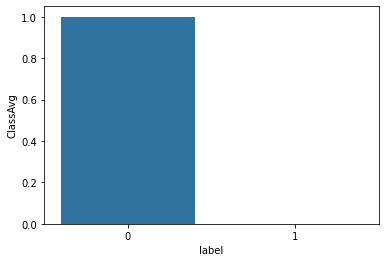

In [ ]:
import seaborn as sns

# Convert the accuracy data frame to Pandas
acc_class_pandas_df = accuracy_by_class.toPandas()

# Construct a barplot
sns.barplot(
  x = "label", y = "ClassAvg", 
  data = acc_class_pandas_df
);

### Gradient-boosted tree classifier

In [ ]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=20,featureSubsetStrategy="auto")

In [ ]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[gbt])
  
model = pipeline.fit(underDF)
prediction = model.transform(test_data_new)
prediction.printSchema()

root
 |-- label: integer (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [ ]:
binEval = MulticlassClassificationEvaluator().setMetricName("accuracy").setPredictionCol("prediction").setLabelCol("label")
    
binEval.evaluate(prediction)

0.6967229536348025

max=10, 0.7089

max=20, 0.6967



### Linear Support Vector Machine

In [ ]:
from pyspark.ml.classification import LinearSVC

In [ ]:
lsvc = LinearSVC().setMaxIter(10).setRegParam(0.01)
lsvcModel = lsvc.fit(underDF)

In [ ]:
prediction = lsvcModel.transform(test_data_new)
binEval = MulticlassClassificationEvaluator().setMetricName("accuracy").setPredictionCol("prediction").setLabelCol("label")
binEval.evaluate(prediction)

0.5961851268841825

max=10, setRegParam=0.01, accuracy=0.596

max=10, setRegParam=0.05, accuracy=0.588

max=10, setRegParam=0.1, accuracy=0.572

max=10, setRegParam=0.2, accuracy=0.5326

### Random forest classifier

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(underDF)
predictions = rfModel.transform(test_data_new)

In [ ]:
binEval = MulticlassClassificationEvaluator().setMetricName("accuracy").setPredictionCol("prediction").setLabelCol("label")
binEval.evaluate(predictions)

0.6933246676842841

accuracy=0.6933